## Car Price Prediction Regression Model
### Project from Machine Learning Bookcamp, Alexey Grigorev
### Copyright 2021, Manning Publications

Written in Python version 3.10.7 <br>
Jupyter Notebook built on Windows 11 local server using VS Code Jupyter Extension v2022.8.1002431955

This project covers the following objectives: 
* Performing exploratory data analysis to identify important features
* Encoding categorical variables for use in ML models
* Using logistic regression with Scikit-learn for classification
* Evaluating model accuracy
* Determining errors and deriving precision/recall from confusion table
* Using receiver operating characteristics an AUC to understand model performance
* Cross-validating a model
* Tuning model parameters for best predictive performance

The main section of the project primarily follows code from book. Occasional comments, explanations, and a few additions are my own. All code and commentary in "Challenge Problems" section (code block 79 to end) is entirely my own.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

Data Source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn <br>
downloaded 27 Sep 2022

In [3]:
len(df)

7043

In [4]:
df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [5]:
#check levels in each column
for col in df.columns:
    unique_vals = pd.unique(df[col])
    if len(unique_vals) <= 10:
        print(f'{col}: {unique_vals}')
    else:
        print(f'{col}: Numeric or than 10 levels')

customerID: Numeric or than 10 levels
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: Numeric or than 10 levels
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: Numeric or than 10 levels
TotalCharges: Numeric or than 10 levels
Churn: ['No' 'Yes']


In [6]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

There are two columns with problems: SeniorCitizen is type `int` and TotalCharges is of type `object` (when it should be `float`). SeniorCitizen is encoded as 1 or 0 instead of yes and no - this actually works fine for later processing, so we won't change it.

TotalCharges needs to be a `float` variable, however. It is likely that there are non-numeric values somewhere in the column, possibly to represent missing data. We will convert first and then replace all `NA` values with 0 - this way the weight of that column will not be considered for those observations in the resulting model.

In [7]:
total_charges = pd.to_numeric(df.TotalCharges, errors = 'coerce')
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [8]:
#set missing values to 0
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors = 'coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

In the original data, capitalization is inconsistent. To make coding a bit easier, we will convert everything to lower case. We also want to do the same to the categorical data itself, along with converting spaces to underscores.

In [9]:
df.columns = df.columns.str.lower()

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

The target variable `churn` is categorical as well (yes or no), but we want to turn this into an integer (1 or 0).

In [10]:
df.churn = (df.churn == 'yes').astype(int)
df.churn.head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int32

Now, we have processed the data to the point where it's workable. We can split into training and test sets using Scikit-learn.

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_train_full, df_test = train_test_split(df, test_size = 0.2, random_state = 1)

df_train_full.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


We also want a validation set, so we run `train_test_split()` again.

In [13]:
df_train, df_val = train_test_split(df_train_full, test_size = 0.33, random_state = 11)
#note: I would have set test_size to 0.25 (20% of full dataset), but leaving as 0.33 to match expected output

#assign result variable (churn) to separate vectors
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

#remove churn column from input data
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [14]:
#check for null values
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [15]:
#check distribution of target variable
df_train_full.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

In [16]:
#find proportion of churned customers
global_mean = df_train_full.churn.mean()
global_mean

0.26996805111821087

Next, we need to separate out the categorical and numerical variables. These will be treated differently in future processing.

In [17]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines',
               'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
               'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [18]:
#get number of unique values for categorical columns
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

To try to figure out which categorical variables are the most important, we can compare the distributions of each level with the overall distribution. If the differences between the category means and overall mean are small, that category may not have a strong relationship with the output of the model. If the differences are large, however, that category is more likely to be important to our outcome.

In [19]:
#start by checking distribution of gender variable
female_mean = df_train_full[df_train_full.gender == 'female'].churn.mean()
male_mean = df_train_full[df_train_full.gender == 'male'].churn.mean()
print(f'Female mean: {female_mean}, Male mean: {male_mean}')

Female mean: 0.27682403433476394, Male mean: 0.2632135306553911


Females and males appear to churn at similar overall rates, all else being equal (though we don't account for variance).

In [20]:
#distribution for partner variable
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print(f'Partner mean: {partner_yes}, No partner mean: {partner_no}')

Partner mean: 0.20503330866025166, No partner mean: 0.3298090040927694


There is a greater difference here. Those without partners (33%) are more likely to churn than those with partners (21%) by a wide margin.

Another way we can account for this is by looking at risk ratio, which is simply the group mean divided by the global mean for negative outcomes.

In [21]:
#this is one area where Python code is less clean than R (w/dplyr) or SQL equivalents
df_group = df_train_full.groupby(by = 'gender').churn.agg(['mean'])
df_group['diff'] = df_group['mean'] - global_mean
df_group['risk'] = df_group['mean'] / global_mean

df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


In [22]:
#now looping through all categorical variables

from IPython.display import display

for col in categorical:
    df_group = df_train_full.groupby(by = col).churn.agg(['mean'])
    df_group['diff'] = df_group['mean'] - global_mean
    df_group['risk'] = df_group['mean'] / global_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


We see that there are fairly significant differences between the categories in likelihood of churning. Some key points:

* Gender and phone service do not appear to have a major impact.
* Senior citizens tend to churn at just over 1.5 times the rate of the rest of the population.
* People with a partner churn less than those without a partner. Likewise for those with and without dependents.
* Those with fiber optic internet churn at a much higher rate than those with DSL or no internet.
* Clients without tech support tend to churn much more than those who do. Likewise for those without online security. 
* People with month-to-month plans churn at a much higher rate than those with contracts. Those with two year contracts especially have a very low risk of churning.

(Our data only covers a single month. The vast majority of those with contracts would have to pay a penalty to stop service unless that month happened to align with the end of their contract term. If the data covered a longer time range, we would relatively higher churn from those under contract, simply because we would capture more contract terms ending. Month-to-month customers would probably still churn at a higher rate, but we should expect the difference would be less extreme.)

One way we can apply this is through the idea of mutual information. We can measure the degree of dependency between two variables to see how closely linked they are, in this case with the target variable, `churn`. If that dependency is very low, we can safely remove it from the dataset. Conversely, for a variable like `contract`, the dependency should be higher, which will indicate the variables that are important to the model.


In [23]:
from sklearn.metrics import mutual_info_score

#stand-alone function for calculating mutual info - later used in apply call
def calculate_mi(series):
    return mutual_info_score(series, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending = False).to_frame(name = 'MI')
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


We can see that `contract`, `onlinesecurity`, and `techsupport` give us the most information about `churn`. `gender` and `phoneservice`, as expected, are at the bottom.

For numeric variables, we can calculate the correlation coefficient for similar effect.

In [24]:
df_train_full[numerical].corrwith(df_train_full.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

Both `tenure` and `totalcharges` have a negative correlation with `churn`, meaning `churn` tends to take on a lower value as they get higher. `monthlycharges` is positively correlated, meaning the opposite. `tenure` is the strongest in absolute correlation.

At this point, since we now have a good understanding of all the variables, we move on to feature engineering and model training.

### Feature Engineering

We begin by encoding categorical variables using one-hot encoding. This is the same technique that we used in the car-price-prediction project (https://github.com/mbalexander19/car_price_prediction), but this time we will use Scikit-learn to implement this. This will certainly take *me* less time than writing a function from scratch, as in the last exercise - and it's almost certainly more efficient from a computation perspective too.

In [25]:
train_dict = df_train[categorical + numerical].to_dict(orient = 'records')
train_dict[0]

{'gender': 'male',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'no',
 'phoneservice': 'yes',
 'multiplelines': 'no',
 'internetservice': 'dsl',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'bank_transfer_(automatic)',
 'tenure': 71,
 'monthlycharges': 86.1,
 'totalcharges': 6045.9}

In [26]:
#use sklearn DictVectorizer to encode
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse = False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [27]:
#convert dict to matrix
X_train = dv.transform(train_dict)
X_train[0]

array([0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       1.0000e+00, 0.0000e+00, 0.0000e+00, 8.6100e+01, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 7.1000e+01, 6.0459e+03])

We can see from the first row of the data that numerical variables are kept intact, while categorical variables are encoded as 1s and 0s. Below, we can view exactly how DictVectorizer split up the categories.

In [28]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'dependents=no', 'dependents=yes',
       'deviceprotection=no', 'deviceprotection=no_internet_service',
       'deviceprotection=yes', 'gender=female', 'gender=male',
       'internetservice=dsl', 'internetservice=fiber_optic',
       'internetservice=no', 'monthlycharges', 'multiplelines=no',
       'multiplelines=no_phone_service', 'multiplelines=yes',
       'onlinebackup=no', 'onlinebackup=no_internet_service',
       'onlinebackup=yes', 'onlinesecurity=no',
       'onlinesecurity=no_internet_service', 'onlinesecurity=yes',
       'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no',
       'partner=yes', 'paymentmethod=bank_transfer_(automatic)',
       'paymentmethod=credit_card_(automatic)',
       'paymentmethod=electronic_check', 'paymentmethod=mailed_check',
       'phoneservice=no', 'phoneservice=yes', 'seniorcitizen',
       'streamingmovies=no', 'streamingmovies=no_internet_service',

### Classification Model

We will now build a logistic regression model to categorize whether individuals are or are not churn risks. The logistic regression model will output a value between 0 and 1, with 0 indicating no risk of churn and 1 indicating a certain churn. 

In reality, it's exceedingly unlikely that we will get outputs at either endpoint directly from the regression model. That means we will need to establish a threshold to divide between churn risks and non-churn risks - values above the threshold will be assigned as churn risks in our classification model, and those below will be assigned as non-churn risks. 

The regression output doesn't mean a definite outcome, but it does allow us to target anti-churn actions to those that are most likely to leave. As an example, we might want to offer those people a discount in return for committing to a new contract so that we don't lose their business altogether. We don't necessarily want to offer this directly to everyone though - there is much less benefit business benefit to offering a discount to those willing to stay at full price.

In [29]:
#this is how we would implement a logistic regression function manually
#we're actually going to use sklearn for this, but this shows a basic "under-the hood" implementation

import math

def sigmoid(score):
    return 1 / (1 + math.exp(-score))

def logistic_regression(xi, w, w_0):
    #xi is a vector of features
    #w is a vector of weights
    #w_0 is the linear bias term
    
    for j in range(len(xi)):
        score = w_0 + xi[j] * w[j]
    
    prob = sigmoid(score)
    return prob

In [30]:
#now we train the model using sklearn

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver = 'liblinear', random_state = 1)
#random_state is seed, solver is optimization library

model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [31]:
#now we can use the model for validation
#but first we have to run DictVectorizer on the validation data
val_dict = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dict)

#then we can run that data through our trained model
y_pred = model.predict_proba(X_val)
y_pred

array([[0.76509419, 0.23490581],
       [0.73114898, 0.26885102],
       [0.68055085, 0.31944915],
       ...,
       [0.94275122, 0.05724878],
       [0.38477228, 0.61522772],
       [0.93872712, 0.06127288]])

The output actually gives us *two* values for each observation, but it's not hard to see that they are dependent - each row adds to 1. The first column is the probability that customer is not a churn risk, while the second column is the probability that customer *is* a churn risk. Naturally, since the customer must either churn or not, these probabilities add to 1 - meaning we can readily work with either column. (Put more technically, these two events are complementary - $Pr(Churn) : 1 - Pr(Churn^{c})$.)

In [32]:
#select only the second column : Pr(churn risk)
y_pred = y_pred[:, 1]

#array is now one-dimensional
y_pred

array([0.23490581, 0.26885102, 0.31944915, ..., 0.05724878, 0.61522772,
       0.06127288])

In a real situation, we would need to decide on a threshold at this point if we didn't already have one. But, for simplicity, we will assume the threshold here is 0.5. Any customer with a `y_pred` value above the threshold will be classified a churn risk, allowing the customer retention team to take focused action.

In [33]:
churn = y_pred >= 0.5
churn.mean()

0.2478494623655914

About 25% of customers are classified as churn risks by this model. This matches well with the actual mean churn frequency of about 27% (calculated earlier), but we can make a better comparison for each individual value in the validation set.

In [34]:
(y_val == churn).mean()

0.8016129032258065

That means that our model predictions matched the true outcome for about 80% of customers in the validation set.

#### Model Interpretation

We can look more deeply at model output to view the coefficients applied. For the categorical variables, this gives some idea of the relative significance of each (the same is *not* necessarily true of numerical variables because they are not normalized - though a value of 0 tells us a variable is excluded entirely).

In [35]:
#first, the bias term
model.intercept_[0]

-0.12198805628903112

In [36]:
#and then the rest of the coefficients
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': 0.563,
 'contract=one_year': -0.086,
 'contract=two_year': -0.599,
 'dependents=no': -0.03,
 'dependents=yes': -0.092,
 'deviceprotection=no': 0.1,
 'deviceprotection=no_internet_service': -0.116,
 'deviceprotection=yes': -0.106,
 'gender=female': -0.027,
 'gender=male': -0.095,
 'internetservice=dsl': -0.323,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.116,
 'monthlycharges': 0.001,
 'multiplelines=no': -0.168,
 'multiplelines=no_phone_service': 0.127,
 'multiplelines=yes': -0.081,
 'onlinebackup=no': 0.136,
 'onlinebackup=no_internet_service': -0.116,
 'onlinebackup=yes': -0.142,
 'onlinesecurity=no': 0.258,
 'onlinesecurity=no_internet_service': -0.116,
 'onlinesecurity=yes': -0.264,
 'paperlessbilling=no': -0.213,
 'paperlessbilling=yes': 0.091,
 'partner=no': -0.048,
 'partner=yes': -0.074,
 'paymentmethod=bank_transfer_(automatic)': -0.027,
 'paymentmethod=credit_card_(automatic)': -0.136,
 'paymentmethod=electronic_check': 0.175,


To better understand how the model is applied, we can look at what happens when we apply a smaller subset of variables. We will train on just three variables this time, `contract`, `tenure`, and `totalcharges`.

In [37]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient = 'records')
dv_small = DictVectorizer(sparse = False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

In [38]:
#view the features used
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'tenure', 'totalcharges'], dtype=object)

`tenure` and `totalcharges` are numeric, so they have not changed in this model. `contract` is still broken down into three categories as in the original model.

In [39]:
#train the model on subset of features
model_small = LogisticRegression(solver = 'liblinear', random_state = 1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [40]:
#check weights
model_small.intercept_[0]

-0.5772299084462216

In [41]:
dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0].round(3)))

{'contract=month-to-month': 0.866,
 'contract=one_year': -0.327,
 'contract=two_year': -1.117,
 'tenure': -0.094,
 'totalcharges': 0.001}

We can use these coefficients to interpret the model. The bias term, approximately -0.58 means that, in the absence of any other information, the customer is more likely to be retained than churned. A look back at the sigmoid formula tells us why: <br><br> $sigmoid(x) : \frac{1}{1 + e^{-x}}$ <br><br>
Since $e^{0} : 1$, any negative value for x will make the expression in the denominator greater than 2.

Similarly, we can see that one and two year contracts tend to bring the probability of churn down in the model - strongly so, for two year contracts - while month-to-month contracts will increase the probability of churn. Tenure drives output slightly toward retention, while totalcharges have almost no effect.

#### Using the Model

Before we try the model out on outside data, we can run our test set through and see how close we get. 

*(Note: even though Machine Learning Bookcamp splits off a test set early on in this project, it doesn't use the `df_test` data in this section (it will be used in the evaluation metrics section later though). Since we're not doing any model comparison here, I ran the test data through just to see if we get similar results to the validation.*

In [42]:
#first we have to run DictVectorizer on the validation data
test_dict = df_test[categorical + numerical].to_dict(orient = 'records')
X_test = dv.transform(test_dict)

#then we can run that data through our model
y_pred = model.predict_proba(X_test)[:, 1]

churn = y_pred >= 0.5
churn.mean()

0.23846699787083037

In [43]:
(y_test == churn).mean()

0.8069552874378992

We get a fairly similar output to the validation set - the proportion of customers for whom churn is predicted is slightly lower, but matches are very slightly higher (about 0.5%). The differences are not enough to be significant, so they increase the confidence that our model is around 80% accurate. Since machine learning is a lot like horseshoes and hand grenades\*, that's pretty good for a first try.

\*(in that being close counts)

Now we can try out our model on a random customer.

In [44]:
customer1 = {
    'customerid': '8879-zkjof',
    'gender': 'female',
    'seniorcitizen' : 0,
    'partner' : 'no',
    'dependents' : 'no',
    'tenure' : 41,
    'phoneservice' : 'yes',
    'multiplelines' : 'no',
    'internetservice' : 'dsl',
    'onlinesecurity' : 'yes',
    'onlinebackup' : 'no',
    'deviceprotection' : 'yes',
    'techsupport' : 'yes',
    'streamingtv' : 'yes',
    'streamingmovies' : 'yes',
    'contract' : 'one_year',
    'paperlessbilling' : 'yes',
    'paymentmethod' : 'bank_transfer_(automatic)',
    'monthlycharges' : 79.85,
    'totalcharges' : 3320.75
}

In [45]:
X_test = dv.transform([customer1])
X_test

array([[0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 7.98500e+01, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 4.10000e+01, 3.32075e+03]])

In [46]:
model.predict_proba(X_test)[:,1]

array([0.07332587])

This customer only has a 7% chance of churning. That's far less than our threshold of 50%, so we would not take any further action with this customer.

In [47]:
#second customer
customer2 = {
    'customerid': '1234-abcde', #this is arbitrary and not used by model
    'gender': 'female',
    'seniorcitizen' : 1,
    'partner' : 'no',
    'dependents' : 'no',
    'tenure' : 1,
    'phoneservice' : 'yes',
    'multiplelines' : 'yes',
    'internetservice' : 'fiber_optic',
    'onlinesecurity' : 'no',
    'onlinebackup' : 'no',
    'deviceprotection' : 'no',
    'techsupport' : 'no',
    'streamingtv' : 'yes',
    'streamingmovies' : 'no',
    'contract' : 'month-to-month',
    'paperlessbilling' : 'yes',
    'paymentmethod' : 'electronic_check',
    'monthlycharges' : 85.7,
    'totalcharges' : 85.7
}

In [48]:
X_test = dv.transform([customer2])
model.predict_proba(X_test)[:,1]

array([0.83216369])

This customer has an 83% chance of churning based on our model, so we *would* take action to try to retain her.

In [49]:
#need to copy y_train to use in out-of-sequence challenge problems
y_train_orig = y_train[:]

### Evaluation Metrics

Now we move onto evaluating our model - essentially, we are determining how good our model is. We did this in a simplistic way earlier, by checking the proportion of predictions that were correct in our validation and test sets; here we will use more advanced methods to get a better idea of model quality and implement improvements.

We with our original quality metric, that is, proportion of matches for the target variable at our given probability threshold of 0.5.

In [50]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8016129032258065

As noted before, however, that threshold of 0.5 was essentially arbitrary. We can improve it by testing different possible values and noting the accuracy score for each.

In [51]:
from sklearn.metrics import accuracy_score

In [52]:
thresholds = np.linspace(0, 1, 11)

for t in thresholds:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    print(f'{t.round(1)}: {acc.round(3)}')

0.0: 0.261
0.1: 0.595
0.2: 0.69
0.3: 0.755
0.4: 0.782
0.5: 0.802
0.6: 0.79
0.7: 0.774
0.8: 0.742
0.9: 0.739
1.0: 0.739


It turns out that 0.5 provided the best accuracy out of the values tested. We can run the model again with additional values and plot them visually as well.

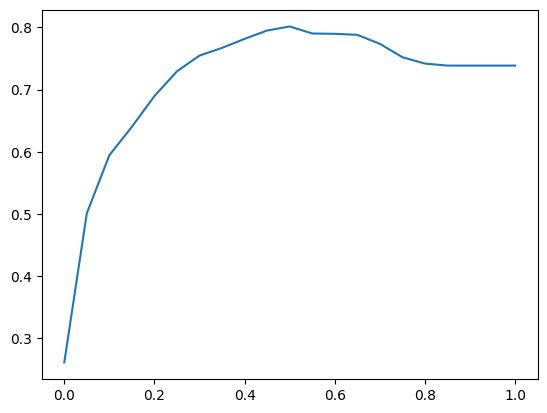

In [53]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    
plt.plot(thresholds, accuracies)

We can also check the accuracy of our small model, using only 3 variables.

In [54]:
val_dict_small = df_val[small_subset].to_dict(orient = 'records')

X_small_val = dv_small.transform(val_dict_small)
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]

churn_small = y_pred_small >= 0.5
accuracy_score(y_val, churn_small)

0.7672043010752688

Our small model is about 3.5% less accurate than our full model - about 80.2% vs. 76.7%. However, this still doesn't give us any real information about how good these accuracy scores really are. For that, we need a baseline to compare the model as a whole against, rather than relative differences between implementations of the same model.

Our investigation of model accuracy for different thresholds gives a clue as to why 80% accuracy might not really be a great result. Even using 1.0 (an effectively unreachable value\*) as a threshold returns a match about 74% of the time - only 6% less than the very best threshold. This is because our dataset is unbalanced - as we saw earlier, only about 27% of customers overall in the dataset actually churned and 73% did not. When we actually check the validation set directly, we find that we would indeed have a match rate of about 74% if we simply assigned everyone to the non-churn category.

\* The reason it is unreachable is that for $\frac{1}{1 + e^{-x}}$ to equal 1, $e^{-x}$ would have to equal 0, which is impossible.

In [55]:
1 - y_val.mean()

###note - the book author suggests the following code to calculate this value
###but the expression above is mathematically identical...and simpler
#size_val = len(y_val)
#baseline = np.repeat(False, size_val)
#accuracy_score(baseline, y_val)

0.7387096774193549

This gives us a useful baseline that we can use to get a better estimate of true model quality. It is worth noting that a 6% improvement over the baseline might turn out to be the best we can do, particularly on a highly complex problem. But it is clear that we need additional detail to truly assess the quality of the model.

For that, we will turn to a confusion table (aka confusion matrix). We will individually caluclate four values - the true positive, true negative, false positive, and false negative. In context, that means:

* True positive: we correctly predict churn
* True negative: we correctly predict no churn
* False positive: we predict churn when no churn occurred
* False negative: we do not predict churn when churn occurred

We can calculate these values using numpy.

In [56]:
t = 0.5 #go back to original threshold of 0.5

#create boolean vectors of predicted and actual values
predict_churn = (y_pred >= t)
predict_no_churn = (y_pred < t)
actual_churn = (y_val == 1)
actual_no_churn = (y_val == 0)

#compare predicted and actual results
true_positive = (predict_churn & actual_churn).sum()
false_positive = (predict_churn & actual_no_churn).sum()
true_negative = (predict_no_churn & actual_no_churn).sum()
false_negative = (predict_no_churn & actual_churn).sum()

confusion_table = np.array(
    [[true_negative, false_positive],
     [false_negative, true_positive]]
)
confusion_table #prints raw quantities for each category

array([[1202,  172],
       [ 197,  289]])

In [57]:
confusion_table / confusion_table.sum() #prints proportions by category

array([[0.64623656, 0.09247312],
       [0.10591398, 0.15537634]])

This gives us a clear view of where our model struggles the most - accurately predicting churn. For non-churning customers, the model successfully predicted 1202/1374 non-churners (87.5%, the specificity) but only 59.5% (289/486, the sensitivity or recall) of churned customers. Precision - the proportion of actual churned customers out of all predicted churners - is 62.7%.

In [58]:
specificity = true_negative / (true_negative + false_positive)
sensitivity = true_positive / (true_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
print(f'Specificity: {specificity.round(3)}, Sensitivity: {sensitivity.round(3)}, Precision: {precision.round(3)}')

Specificity: 0.875, Sensitivity: 0.595, Precision: 0.627


One limitation of the metrics we just calculated is that they only work for binary predictions. If we want to compare the model across multiple threshold values, for instance, it is more appropriate to use a multi-factor model.

One such model is known as the "receiver operating characteristic", or ROC. It is useful for testing a classification model (that is, a model with two outcomes) across a variety of conditions. ROC considers two values, the false positive rate (equivalent to 1-specificity or $\frac{FP}{FP + TN}$) and true positive rate (equivalent to sensitivity or $\frac{TP}{TP + FN}$).

We will iterate through the full range of posible threshold values to develop the ROC curves.

In [59]:
scores = []

thresholds = np.linspace(0, 1, 101) #increment threshold by 0.01

for t in thresholds:
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores) #turn list of tuples into DataFrame
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


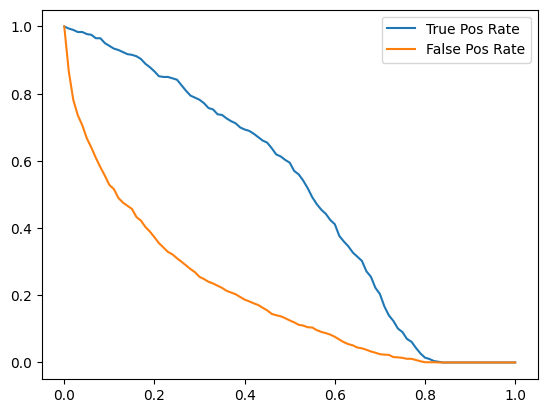

In [60]:
#create true positive rate and false positive rate columns
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

#plot TPR and FPR curves
plt.plot(df_scores.threshold, df_scores.tpr, label = 'True Pos Rate')
plt.plot(df_scores.threshold, df_scores.fpr, label = 'False Pos Rate')
plt.legend()

An ideal model would produce a true positive rate near 1 and a false positive rate near 0 for the same threshold value. Another way to visualize this is that true positive rate should stay high for as long as possible while false positive rate should drop to 0 as quickly as possible.

We can see visually that our model does not meet those requirements. While false positive rate does drop off quickly, true positive rate also falls away from 1 even for low thresholds.

To understand this better, and also get an idea of how to improve our model, we can look at the TPR and FPR curves for a random model as well as for an ideal model.

In [61]:
#random model

#write function to calculate tpr and fpr
def tpr_fpr_df(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101) #increment threshold by 0.01

    for t in thresholds:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()
        scores.append((t, tp, fp, fn, tn))
    
    df_scores = pd.DataFrame(scores) #turn list of tuples into DataFrame
    df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

#create random data
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size = len(y_val))

#process using calc function
df_rand = tpr_fpr_df(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


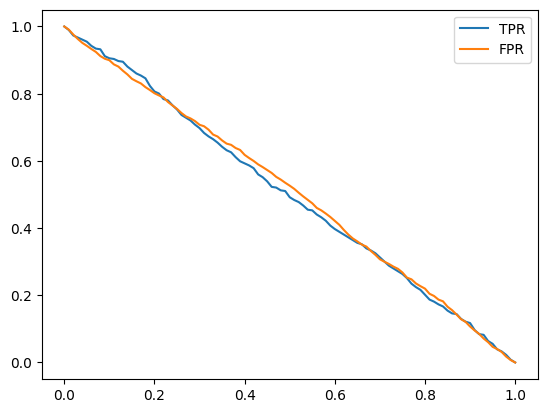

In [62]:
plt.plot(df_rand.threshold, df_rand.tpr, label = 'TPR')
plt.plot(df_rand.threshold, df_rand.fpr, label = 'FPR')
plt.legend()

As expected, the random data shows nearly identical straight lines for TPR and FPR, because the random output is completely uncorrelated to the actual results of our data.

Next, we can set up an "ideal" model to visualize what that would look like.

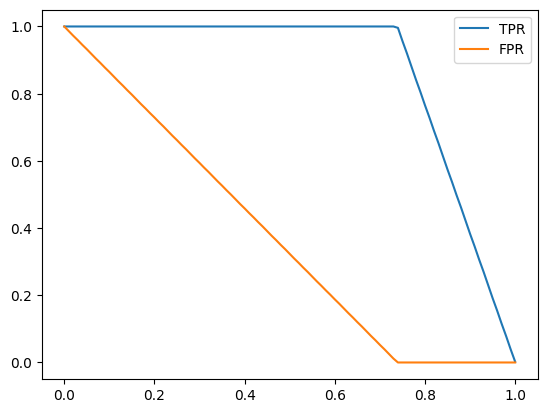

In [63]:
#calculate number of negative and positive examples in real dataset
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

#generates array of num_neg sequential 0s followed by num_pos sequential 1s
y_ideal = np.repeat([0,1], [num_neg, num_pos])

#generates "predictions" - numbers that grow linearly from 0 to 1
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = tpr_fpr_df(y_ideal, y_pred_ideal)

plt.plot(df_ideal.threshold, df_ideal.tpr, label = 'TPR')
plt.plot(df_ideal.threshold, df_ideal.fpr, label = 'FPR')
plt.legend()

In this plot, we correctly classify all churning customers below the threshold of 0.74, because we constructed the sequence in such a way that this is the lowest "prediction" a churning customer could take. Conversely, our false positive rate drops linearly from 0 of 0.74, so that we correctly classify all non-churners above 0.74. Though unrealistic, this shows the optimal situation - a threshold value at which we can perfectly separate the two categories.

Now, we can move onto an ROC curve. This plots TPR vs. FPR for different thresholds against each other rather than the model output. We will also show the random and ideal scenarios.

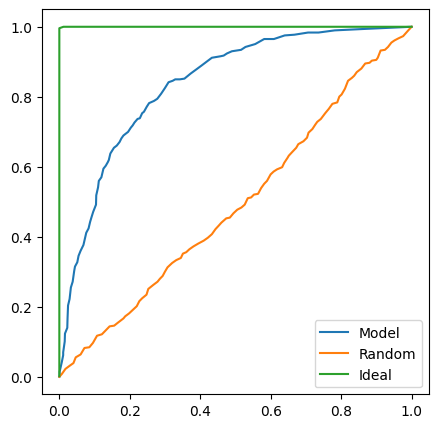

In [64]:
plt.figure(figsize = (5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label = 'Model')
plt.plot(df_rand.fpr, df_rand.tpr, label = 'Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label = 'Ideal')

plt.legend()

An ideal model would get us as close to the upper left corner as possible. It should also be noted that we can replace the random curve with the straight line y = x.

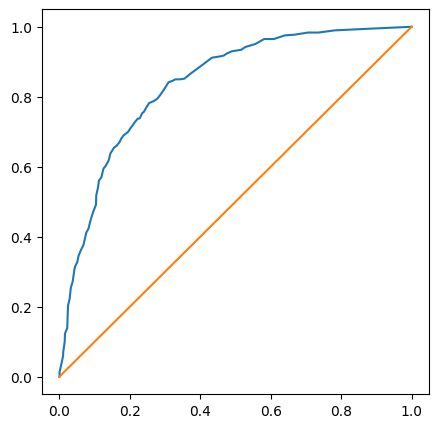

In [65]:
plt.figure(figsize = (5,5))
plt.plot(df_scores.fpr, df_scores.tpr)
plt.plot([0,1],[0,1])

We can also do this with a sklearn function!

In [66]:
from sklearn.metrics import roc_curve

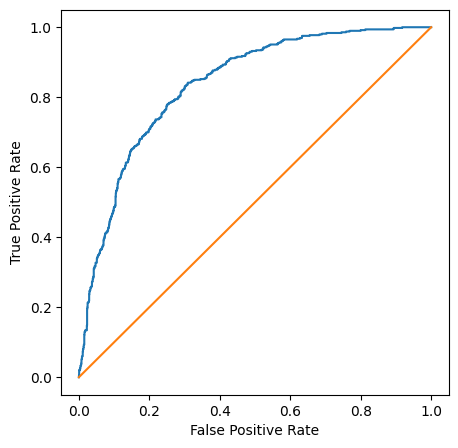

In [67]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize = (5,5))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])

To make sense of this plot, we need to do a bit of further investigation. We can tell from our original TPR-FPR plot that the line goes from top right to bottom left as threshold goes from 0 to 1 (when threshold is 0, TPR and FPR are at (1,1); when threshold is 1, TPR and FPR are at(0,0)).

The intermediate values are difficult to associate directly with a threshold, but the general trend is that we want a curve that goes as close to the top left corner as possible. That would be a situation where true positive rate remains close to 1 while false positive rate drops to near 0. The closer the ROC curve is to the "random" straight diagonal, the less effective our model is.

We can also plot multiple ROC curves to compare similar models. As an example, we can do this with our full and small models.

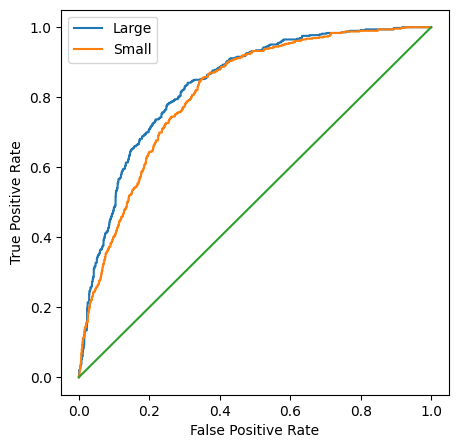

In [68]:
fpr_large, tpr_large, _ = roc_curve(y_val, y_pred)
fpr_small, tpr_small, _ = roc_curve(y_val, y_pred_small)

plt.figure(figsize = (5,5))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_large, tpr_large, label = 'Large')
plt.plot(fpr_small, tpr_small, label = 'Small')
plt.plot([0,1],[0,1])
plt.legend()

A quantitative way to express the "closeness" to the top left is finding the area under the ROC curve (AUC). A perfectly square curve would have an AUC of 1 - the best possible metric - while a totally random model would produce an AUC of 0.5. Generally, 0.9 indicates a good model, 0.8 is moderately good, 0.7 is moderately poor, and 0.6 is poor. We can use sklearn (again) to find the AUC for our models.

In [69]:
from sklearn.metrics import auc

In [70]:
auc(df_scores.fpr, df_scores.tpr)

0.8359150837721111

If we didn't have the TPR and FPR already calculated, we could use the `roc_auc_score` function from sklearn instead.

In [71]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8363381374257972

In [72]:
#and for the small model
roc_auc_score(y_val, y_pred_small)

0.8117942866042492

We can interpret these results as the probability that a churning customer scores higher than a non-churning one. We can verify this by running a simulation to directly calculate this probability and comparing with our AUC value.

In [73]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

np.random.seed(1)
neg_choice = np.random.randint(low = 0, high = len(neg), size = 10000)
pos_choice = np.random.randint(low = 0, high = len(pos), size = 10000)

(pos[pos_choice] > neg[neg_choice]).mean()

0.8356

We end up with a nearly identical value - within 0.01 of our AUC calculation.

This, again, gives us a metric that is useful for evaluating our model. In a purely random dataset, we would expect the output of this simulation to be 0.5. In a perfect model, it would be exactly 1. That lines up exactly with the numerical output of AUC - so while we don't necessarily need to repeat both the AUC calculation and the simulation in the real world, the simulation method can help in interpreting the model for anyone unfamiliar with the concept.

### Parameter Tuning

The hold-out validation method we used earlier is effective, but simplistic and relatively vulnerable to random effects in the data. Another, more robust, method we can use is k-fold cross validation (CV). The basic algorithm is to create k even partitions of the full dataset, then use k-1 of the folds for training and the last for validation. We repeat this for every combination of training and validation sets, in effect running the training and validation k separate times. We will (likely) get a slightly different output each time, while controlling more effectively for random noise because we will validate across the entire dataset (using each observation exactly once) rather than a more limited subset.

In [74]:
#modify our dataset training to incorporate entire df

#train original dataset
#applies one-hot encoding and trains model
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver = 'liblinear')
    model.fit(X,y)
    
    return dv, model

#predict outcomes for new data
#applies same encoding scheme as training set and makes predictions
def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient = 'records')
    
    X = dv.transform(cat)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [75]:
from sklearn.model_selection import KFold

In [76]:
#set up k-fold CV with 10 random partitions
kfold = KFold(n_splits = 10, shuffle = True, random_state = 1)

aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    #split training and validation sets
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]
    
    #separate true outputs
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    #train on training set - the churn column is selected out inside the train function
    dv, model = train(df_train, y_train)
    
    #get predictions from validation set
    y_pred = predict(df_val, dv, model)
    
    #calculate AUC and append to list of outputs
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

print(f'AUC = {np.mean(aucs).round(3)} +/- {(1.96 * np.std(aucs)).round(3)} (95% CI)') 
#CI is approximate - assuming normal distribution of sample means based on CLT

AUC = 0.842 +/- 0.023 (95% CI)


This allows us to not only get a more accurate characterization of our model performance, we can also calculate the variation. Our original model had an AUC (0.836) slightly below this mean, but within the CI. 

It is worth noting, however, that the training sets were are using here are somewhat larger than we used for the original model. Because we use 10 folds, 90% of the data is used in training for each iteration, compared to 66.7% in our original model. Because of that, we should expect the typical model output to be slightly better simply due to having a larger amount of data used in building the model.

In the car-price-prediction project, we took the additional step of selecting a regularization factor to improve our model. We can do that here as well through the addition of an additional parameter to our `train` function, which we then pass into the sklearn `LogisticRegression` object.

In [77]:
def train(df, y, C = 1):
    cat = df[categorical + numerical].to_dict(orient = 'records')
    
    dv = DictVectorizer(sparse = False)
    dv.fit(cat)
    
    X = dv.transform(cat)
    
    model = LogisticRegression(solver = 'liblinear', C = C) #pass in additional regularization factor C
    model.fit(X,y)
    
    return dv, model

nfolds = 5

#set up k-fold CV with 10 random partitions
kfold = KFold(n_splits = nfolds, shuffle = True, random_state = 1)

for C in range(-3, 2):
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        #split training and validation sets
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
        
        #separate true outputs
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        #train on training set - the churn column is selected out inside the train function
        dv, model = train(df_train, y_train, C = 10**C)
        
        #get predictions from validation set
        y_pred = predict(df_val, dv, model)
        
        #calculate AUC and append to list of outputs
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)
        
    print(f'C = {10**C}, AUC = {np.mean(aucs).round(3)} +/- {(1.96 * np.std(aucs)).round(3)} (95% CI)') 
    #CI is approximate - assuming normal distribution of sample means based on CLT

C = 0.001, AUC = 0.825 +/- 0.026 (95% CI)
C = 0.01, AUC = 0.839 +/- 0.017 (95% CI)
C = 0.1, AUC = 0.841 +/- 0.016 (95% CI)
C = 1, AUC = 0.841 +/- 0.014 (95% CI)
C = 10, AUC = 0.841 +/- 0.015 (95% CI)


It appears that for C >= 0.01, we get consistent model outcomes, although with slight differences in the variance. In general, it is best to choose the lowest regularization coefficient `C` that gives us the model quality we want, since that helps to keep the model weights low and better predict new data. For that reason, we will use C = 0.1 in our test set, since it combines the best mean performance with only a very slight increase in variance from C = 0.01.

Now, we can train the model on these predictions and use the test set (which we set aside very early on) to get our final estimate of model quality.

In [78]:
y_train = df_train_full.churn.values

dv, model = train(df_train_full, y_train, C = 0.1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print(f'AUC = {auc.round(3)}')

AUC = 0.858


## Challenge Problems (Ch. 3)

### Exercise 1 - Try to redo the car_price_prediction problem from the previous chapter with Scikit-learn.

Response is found in car_price_prediction repository, https://github.com/mbalexander19/car_price_prediction/blob/main/car-price-project-sklearn.ipynb.

### Exercise 2 - We looked at feature importance metrics but didn't really use them. See what happens to the model when some non-useful features (for example, `gender` and `phoneservices`) are excluded. Also see what happens if we exclude the most useful feature (`contract`).

*Note: this exercise falls sequentially before the evaluation metrics section. Thus, it does not incorporate the confusion table, ROC/AUC, and k-fold CV methods discussed above. Because this exercise modifies some of the code from the original project, I moved it out of sequence to avoid unintended effects on the data in the main portion of the project.*

In [79]:
#modify list of categorical vars - numerical vars don't change
categorical_mod = ['seniorcitizen', 'partner', 'dependents', 'multiplelines',
               'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
               'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']

In [80]:
#re-encode variables
train_dict_mod = df_train_full[categorical_mod + numerical].to_dict(orient = 'records')

#run DictVectorizer
dv = DictVectorizer(sparse = False)
dv.fit(train_dict_mod)

#train model
X_train_mod = dv.transform(train_dict_mod)

model = LogisticRegression(solver = 'liblinear', random_state = 1)
model.fit(X_train_mod, y_train) #target data doesn't change

#re-encode validation set
val_dict_mod = df_val[categorical_mod + numerical].to_dict(orient = 'records')
X_val_mod = dv.transform(val_dict_mod)

#predict values
y_pred = model.predict_proba(X_val_mod)[:,1]


In [81]:
churn = y_pred >= 0.5
churn.mean()

0.23623445825932504

In [82]:
(y_val == churn).mean()

0.8117229129662522

Our model quality with `gender` and `phoneservices` removed is virtually identical to the original model with all variables. That is to be expected - our original analysis indicated these variables don't contribute much to the model.

Now we'll run the model again, with only `contract` removed.

In [83]:
categorical_mod2 = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 'multiplelines',
               'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
               'streamingtv', 'streamingmovies', 'paperlessbilling', 'paymentmethod']

In [84]:
#re-encode variables
train_dict_mod2 = df_train_full[categorical_mod2 + numerical].to_dict(orient = 'records')

#run DictVectorizer
dv = DictVectorizer(sparse = False)
dv.fit(train_dict_mod2)

#train model
X_train_mod2 = dv.transform(train_dict_mod2)

model = LogisticRegression(solver = 'liblinear', random_state = 1)
model.fit(X_train_mod2, y_train) #target data doesn't change

#re-encode validation set
val_dict_mod2 = df_val[categorical_mod2 + numerical].to_dict(orient = 'records')
X_val_mod2 = dv.transform(val_dict_mod2)

#predict values
y_pred = model.predict_proba(X_val_mod2)[:,1]

In [85]:
churn = y_pred >= 0.5
churn.mean()

0.216696269982238

In [86]:
(y_val == churn).mean()

0.8117229129662522

Our model quality *still* appear to be nearly identical to the original - within 1% accuracy. This is a bit more surprising than the previous result, but still not terribly unusual. There is enough mutual information between `contract` and the rest of the variables combined that our model can come to the same conclusions even without `contract` being explicitly included.

While we wouldn't necessarily want to exclude `contract` from our current model (we already have the data, after all), but it does mean that our model should remain usable even if the company moves away from the existing contract structure. If, for instance, the company decided to move everyone to a non-contract (effectively month-to-month) payment structure, `contract` probably would no longer be useful (because everyone would have the same kind). But it appears we get enough information from the rest of the variables that we could still use the original model while awaiting new data reflecting the change.